#  Predictive Modelling to Mitigate Public Health Risks by fuzzy Deep Learning Approach
## Research Project Notebook

*By Harshvardhan Bahukhandi, Swayam kaushal, Vaibhav Arya*  
*Department of Computer Science engineering*

## 1. Environment Setup & Imports

In [1]:
# Core Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Dense, Concatenate, Dropout, BatchNormalization, Reshape, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping


In [14]:
# Data Processing & ML
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix
import joblib



In [16]:
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 17.3 MB/s eta 0:00:00


In [17]:
# Fuzzy Logic
import skfuzzy as fuzz
from skfuzzy import control as ctrl

In [18]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [19]:
# System
import warnings
warnings.filterwarnings('ignore')

## 2. Data Loading & Preliminary Analysis

In [20]:
# Load dataset
df = pd.read_csv('air_quality_health_impact_data.csv')

In [21]:
# Display dataset structure
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (5811, 15)


,RecordID,AQI,PM10,PM2_5,NO2,SO2,O3,Temperature,Humidity,WindSpeed,RespiratoryCases,CardiovascularCases,HospitalAdmissions,HealthImpactScore,HealthImpactClass
0,1,187.270059,295.853039,13.038560,6.639263,66.161150,54.624280,5.150335,84.424344,6.137755,7,5,1,97.244041,0.0
1,2,475.357153,246.254703,9.984497,16.318326,90.499523,169.621728,1.543378,46.851415,4.521422,10,2,0,100.000000,0.0
2,3,365.996971,84.443191,23.111340,96.317811,17.875850,9.006794,1.169483,17.806977,11.157384,13,3,0,100.000000,0.0
3,4,299.329242,21.020609,14.273403,81.234403,48.323616,93.161033,21.925276,99.473373,15.302500,8,8,1,100.000000,0.0
4,5,78.009320,16.987667,152.111623,121.235461,90.866167,241.795138,9.217517,24.906837,14.534733,9,0,1,95.182643,0.0


### 2.1 Data Description


In [22]:
# Basic statistics
df.describe().T.style.background_gradient(cmap='Blues')

,count,mean,std,min,25%,50%,75%,max
RecordID,5811.000000,2906.000000,1677.635538,1.000000,1453.500000,2906.000000,4358.500000,5811.000000
AQI,5811.000000,248.438476,144.777638,0.005817,122.951293,249.127841,373.630668,499.858837
PM10,5811.000000,148.654997,85.698500,0.015848,75.374954,147.634997,222.436759,299.901962
PM2_5,5811.000000,100.223714,58.096612,0.031549,49.435171,100.506337,151.340260,199.984965
NO2,5811.000000,102.293445,57.713175,0.009625,53.538538,102.987736,151.658516,199.980195
SO2,5811.000000,49.456838,28.530329,0.011023,24.887264,49.530165,73.346617,99.969561
O3,5811.000000,149.312431,86.534240,0.001661,73.999665,149.559871,223.380126,299.936812
Temperature,5811.000000,14.975500,14.483067,-9.990998,2.481500,14.942428,27.465374,39.963434
Humidity,5811.000000,54.776853,26.020786,10.001506,31.995262,54.543904,77.641639,99.997493
WindSpeed,5811.000000,9.989177,5.776950,0.002094,4.952343,10.051742,14.971840,19.999139


In [23]:
# Data types & missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5811 entries, 0 to 5810
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   RecordID             5811 non-null   int64  
 1   AQI                  5811 non-null   float64
 2   PM10                 5811 non-null   float64
 3   PM2_5                5811 non-null   float64
 4   NO2                  5811 non-null   float64
 5   SO2                  5811 non-null   float64
 6   O3                   5811 non-null   float64
 7   Temperature          5811 non-null   float64
 8   Humidity             5811 non-null   float64
 9   WindSpeed            5811 non-null   float64
 10  RespiratoryCases     5811 non-null   int64  
 11  CardiovascularCases  5811 non-null   int64  
 12  HospitalAdmissions   5811 non-null   int64  
 13  HealthImpactScore    5811 non-null   float64
 14  HealthImpactClass    5811 non-null   float64
dtypes: float64(11), int64(4)
memory usage:

### 2.2 Data Visualization

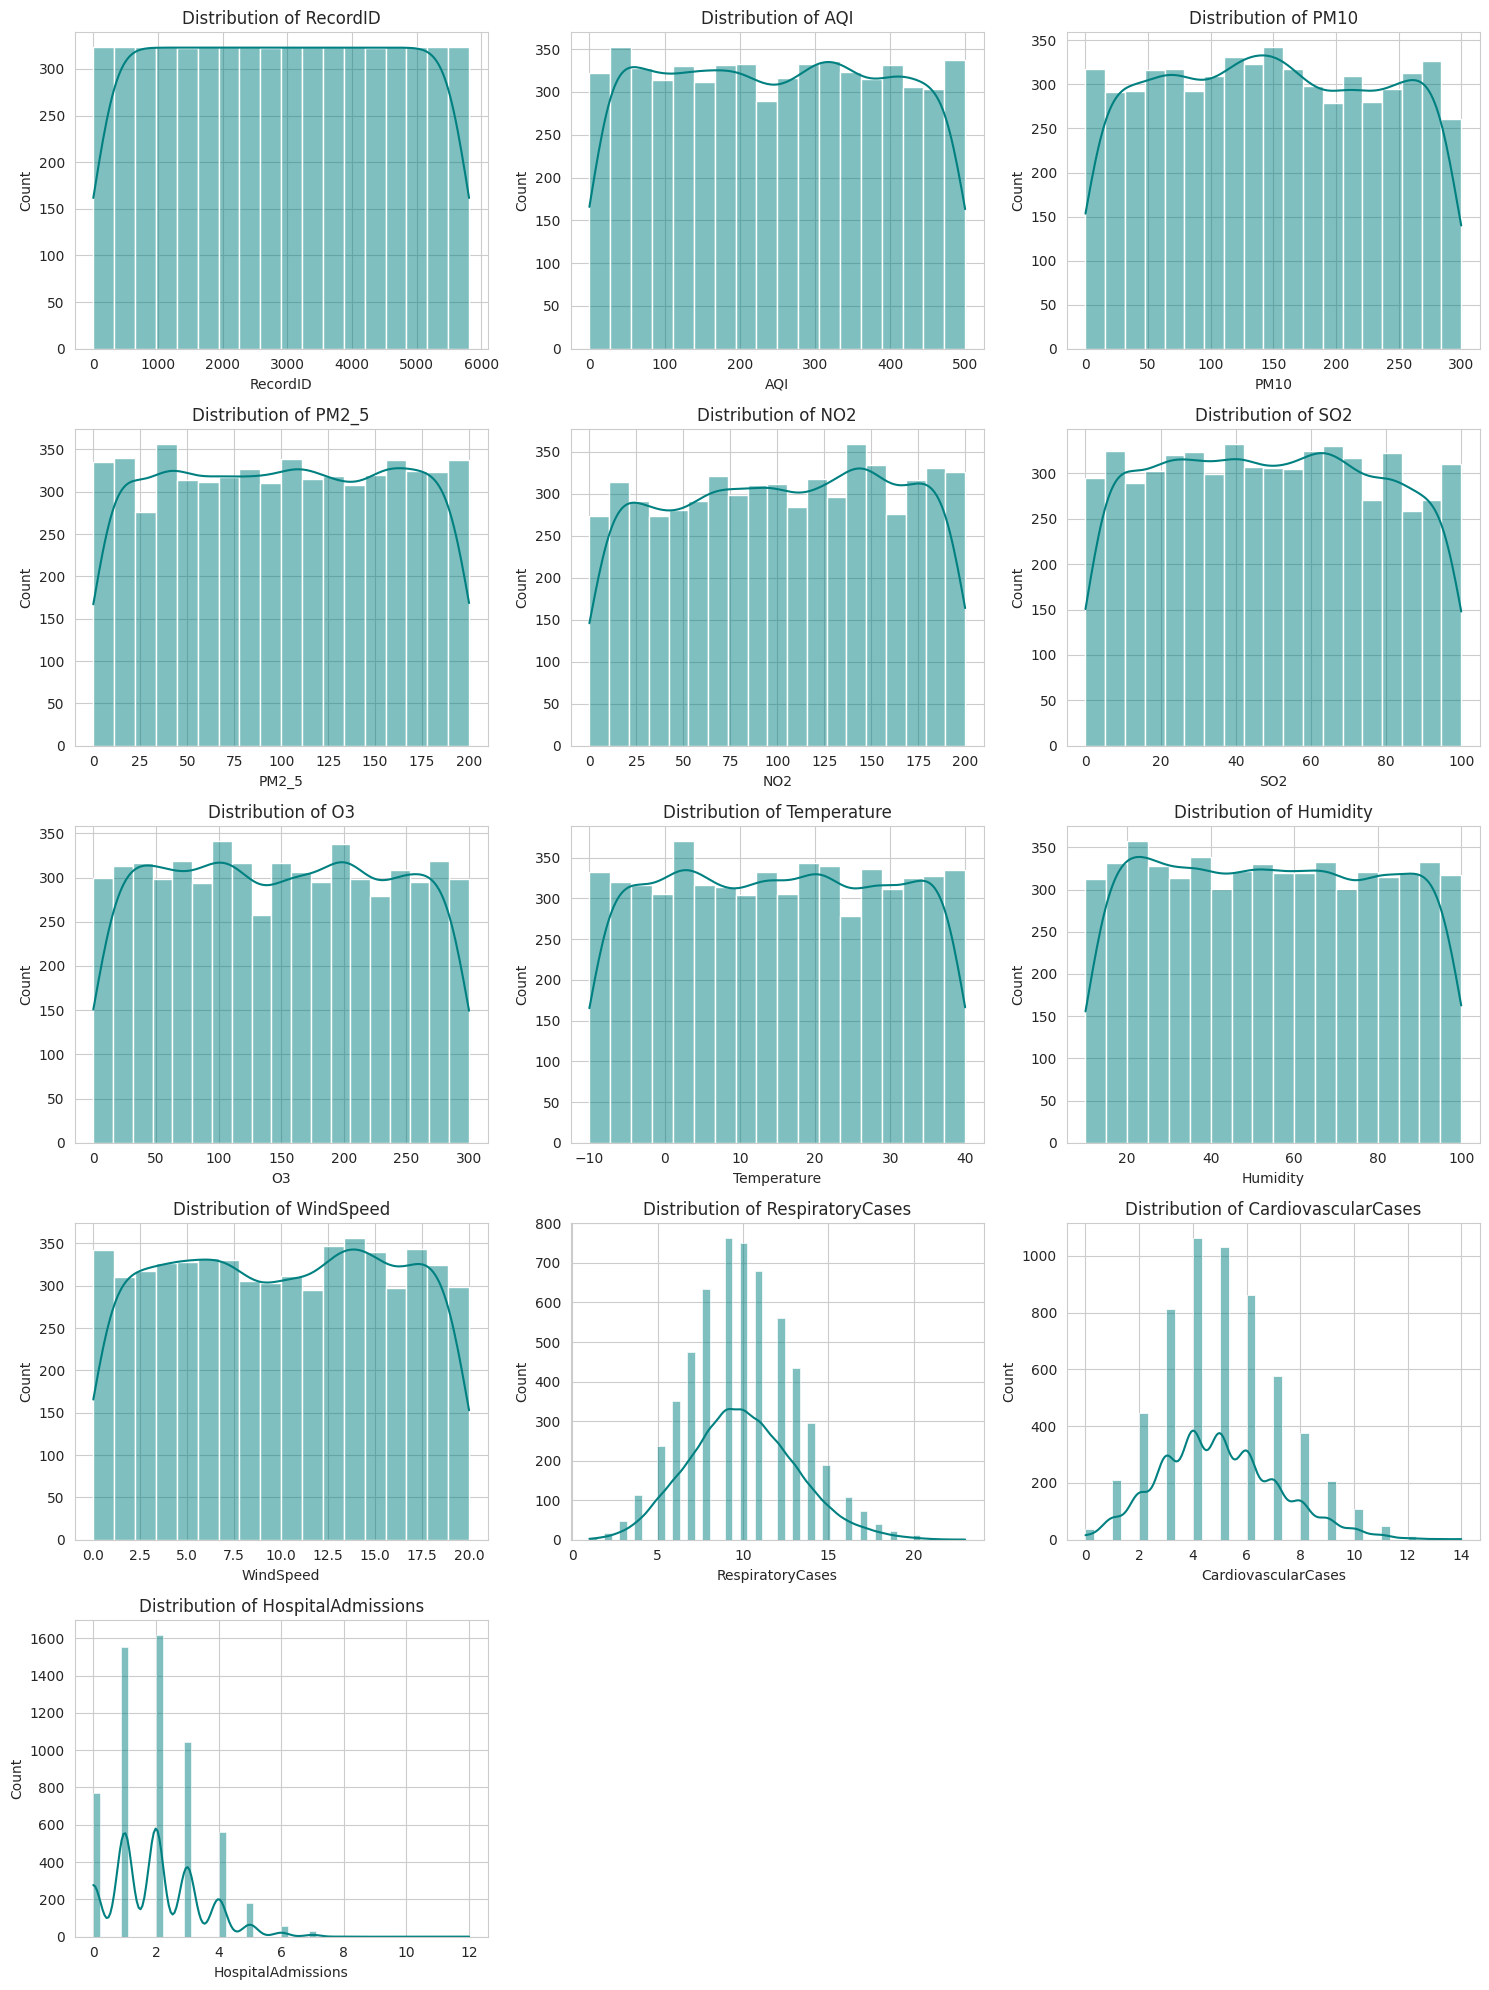

In [25]:
import math

num_plots = len(df.columns[:-2])
cols = 3
rows = math.ceil(num_plots / cols)

plt.figure(figsize=(5 * cols, 4 * rows))
for i, col in enumerate(df.columns[:-2], 1):
    plt.subplot(rows, cols, i)
    sns.histplot(df[col], kde=True, color='teal')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


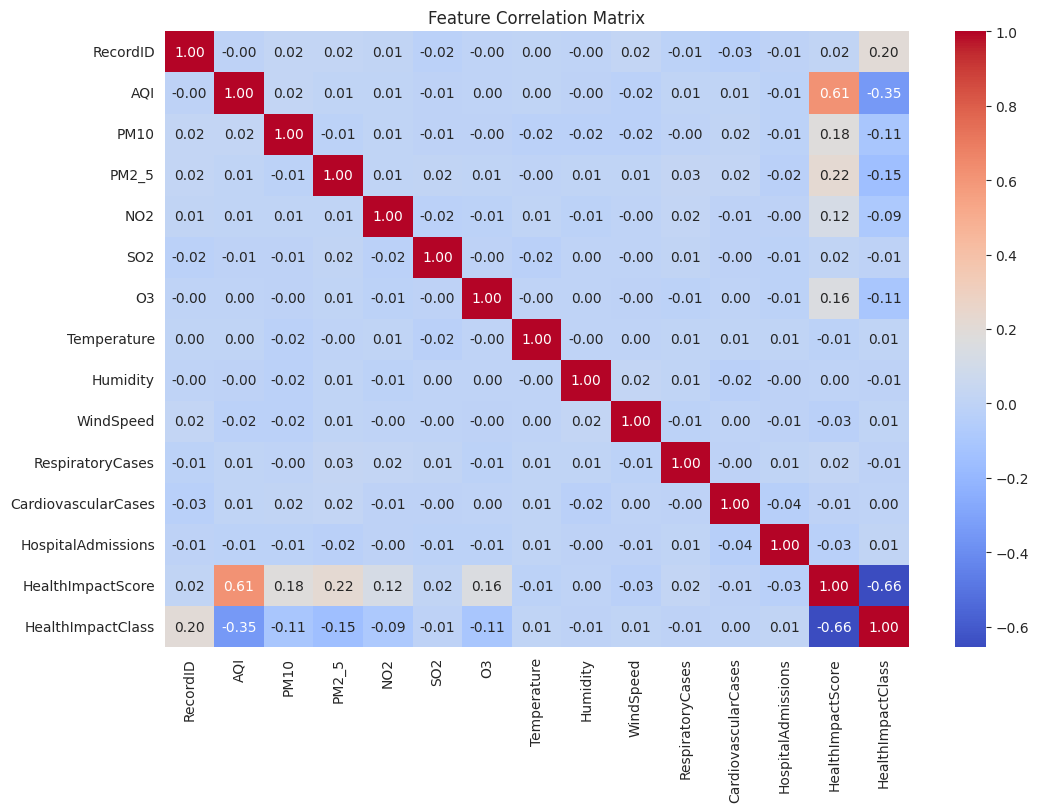

In [26]:
# Correlation analysis
plt.figure(figsize=(12,8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

## 3. Data Preprocessing

In [27]:
# Feature-Target Separation
features = ['AQI', 'PM10', 'PM2_5', 'NO2', 'SO2', 'O3']
targets = ['HealthImpactScore', 'HealthImpactClass']

In [28]:
X = df[features].values
y_score = df[targets[0]].values
y_class = pd.cut(df[targets[0]], bins=[0, 50, 100, 200], labels=[0, 1, 2]).astype(int)

In [29]:
# Train-Test Split
X_train, X_test, y_score_train, y_score_test, y_class_train, y_class_test = train_test_split(
    X, y_score, y_class, test_size=0.2, random_state=42, stratify=y_class
)


In [30]:
# Scaling
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 4. Fuzzy Logic System Implementation

In [31]:
# Define custom Fuzzy Membership Layer (XLA-Compatible Version)
class FuzzyMembershipLayer(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.output_dim = 1

    def build(self, input_shape):
        # AQI membership functions
        self.aqi_low = self._create_tf_trimf(0, 0, 50)
        self.aqi_mod = self._create_tf_trimf(35, 75, 125)
        self.aqi_high = self._create_tf_trimf(100, 175, 300)
        self.aqi_severe = self._create_tf_trimf(250, 400, 500)

        # PM2.5 membership functions
        self.pm25_low = self._create_tf_trimf(0, 0, 15)
        self.pm25_mod = self._create_tf_trimf(10, 25, 40)
        self.pm25_high = self._create_tf_trimf(35, 50, 75)
        self.pm25_severe = self._create_tf_trimf(60, 100, 250)

        # Health risk output
        self.risk_low = self._create_tf_trimf(0, 0, 25)
        self.risk_mod = self._create_tf_trimf(20, 50, 80)
        self.risk_high = self._create_tf_trimf(70, 85, 100)

        super().build(input_shape)

    def _create_tf_trimf(self, a, b, c):
        def trimf(x):
            return tf.maximum(
                tf.minimum((x - a)/(b - a), (c - x)/(c - b)),
                0.0
            )
        return trimf

    def call(self, inputs):
        aqi = inputs[:, 0]
        pm25 = inputs[:, 2]

        # Calculate membership values
        aqi_mem = {
            'low': self.aqi_low(aqi),
            'mod': self.aqi_mod(aqi),
            'high': self.aqi_high(aqi),
            'severe': self.aqi_severe(aqi)
        }

        pm25_mem = {
            'low': self.pm25_low(pm25),
            'mod': self.pm25_mod(pm25),
            'high': self.pm25_high(pm25),
            'severe': self.pm25_severe(pm25)
        }

        # Apply fuzzy rules using TensorFlow operations
        rule1 = tf.minimum(aqi_mem['low'], pm25_mem['low'])
        rule2 = tf.minimum(aqi_mem['mod'], pm25_mem['mod'])
        rule3 = tf.minimum(aqi_mem['high'], pm25_mem['high'])
        rule4 = tf.minimum(aqi_mem['severe'], pm25_mem['severe'])

        # Aggregate and defuzzify
        risk_low = rule1 * self.risk_low(tf.constant(12.5))  # Center of low risk
        risk_mod = rule2 * self.risk_mod(tf.constant(50.0))  # Center of mod risk
        risk_high = (rule3 + rule4) * self.risk_high(tf.constant(85.0))  # Center of high risk

        numerator = risk_low + risk_mod + risk_high
        denominator = rule1 + rule2 + rule3 + rule4 + 1e-7
        crisp_output = numerator / denominator

        return tf.reshape(crisp_output, (-1, 1))

## 5. Hybrid Neural Network Architecture

In [38]:
# Main Health Impact Predictor Class
class HealthImpactPredictor:
    def __init__(self, input_dim, num_classes=3):
            self.input_dim = input_dim
            self.num_classes = num_classes
            self.scaler = RobustScaler()
            self.model = self._build_model()


    def _create_fuzzy_system(self):
        # Define fuzzy variables
        aqi = ctrl.Antecedent(np.linspace(0, 500, 500), 'aqi')
        pm25 = ctrl.Antecedent(np.linspace(0, 250, 500), 'pm25')
        health_risk = ctrl.Consequent(np.linspace(0, 100, 100), 'risk')

        # Membership functions
        aqi['low'] = fuzz.trimf(aqi.universe, [0, 0, 50])
        aqi['moderate'] = fuzz.trimf(aqi.universe, [35, 75, 125])
        aqi['high'] = fuzz.trimf(aqi.universe, [100, 175, 300])
        aqi['severe'] = fuzz.trimf(aqi.universe, [250, 400, 500])

        pm25['low'] = fuzz.trimf(pm25.universe, [0, 0, 15])
        pm25['moderate'] = fuzz.trimf(pm25.universe, [10, 25, 40])
        pm25['high'] = fuzz.trimf(pm25.universe, [35, 50, 75])
        pm25['severe'] = fuzz.trimf(pm25.universe, [60, 100, 250])

        health_risk['low'] = fuzz.trimf(health_risk.universe, [0, 0, 25])
        health_risk['moderate'] = fuzz.trimf(health_risk.universe, [20, 50, 80])
        health_risk['high'] = fuzz.trimf(health_risk.universe, [70, 85, 100])

        # Define rules
        rules = [
            ctrl.Rule(aqi['low'] & pm25['low'], health_risk['low']),
            ctrl.Rule(aqi['moderate'] & pm25['moderate'], health_risk['moderate']),
            ctrl.Rule(aqi['high'] & pm25['high'], health_risk['high']),
            ctrl.Rule(aqi['severe'] & pm25['severe'], health_risk['high'])
        ]

        return ctrl.ControlSystem(rules)


    def _build_model(self):
        inputs = Input(shape=(self.input_dim,))

        # Fuzzy processing (now fully TensorFlow compatible)
        fuzzy_features = FuzzyMembershipLayer()(inputs)

        # Rest of the model remains the same
        x = Dense(128, activation='swish')(inputs)
        x = Dropout(0.3)(x)

        combined = Concatenate()([x, fuzzy_features])
        x = BatchNormalization()(combined)

        # Attention mechanism
        sequence_length = 3
        x_reshaped = Reshape((sequence_length, -1))(x)
        att = Attention()([x_reshaped, x_reshaped])
        att = Reshape((-1,))(att)

        x = Concatenate()([x, att])

        score = Dense(1, name='score')(x)
        cls = Dense(self.num_classes, activation='softmax', name='class')(x)

        return Model(inputs, [score, cls])

    def train(self, X, y_score, y_class):
        # Preprocess data
        X_scaled = self.scaler.fit_transform(X)
        # inside HealthImpactPredictor.train()
        # specify num_classes=3 so you always get shape (None, 3)
        y_class_cat = to_categorical(y_class, num_classes=self.num_classes)


        # Compile model
        self.model.compile(
            optimizer=Adam(3e-4),
            loss={'score': 'mse', 'class': 'categorical_crossentropy'},
            metrics={'class': 'accuracy'}
        )

        # Train model
        history = self.model.fit(
            X_scaled,
            {'score': y_score, 'class': y_class_cat},
            epochs=200,
            batch_size=64,
            validation_split=0.2,
            callbacks=[tf.keras.callbacks.EarlyStopping(patience=15)]
        )
        return history

    def evaluate(self, X, y_score, y_class):
        X_scaled = self.scaler.transform(X)
        y_class_cat = to_categorical(y_class, num_classes=self.num_classes)  # Fixed line
        return self.model.evaluate(X_scaled, [y_score, y_class_cat], verbose=0)

    def save(self, path):
        self.model.save(f'{path}_model.keras')
        joblib.dump(self.scaler, f'{path}_scaler.pkl')

    @classmethod
    def load(cls, path):
        model = tf.keras.models.load_model(
            f'{path}_model.keras',
            custom_objects={'FuzzyMembershipLayer': FuzzyMembershipLayer}
        )
        scaler = joblib.load(f'{path}_scaler.pkl')
        predictor = cls(model.input_shape[1])
        predictor.model = model
        predictor.scaler = scaler
        return predictor


## 6. Model Training & Evaluation

In [39]:
# Initialize model
predictor = HealthImpactPredictor(input_dim=X_train.shape[1], num_classes=3)


In [40]:
# Compile model and Training
history = predictor.train(X_train, y_score_train, y_class_train)


Epoch 1/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - class_accuracy: 0.2934 - class_loss: 1.4242 - loss: 8981.0166 - score_loss: 8979.4414 - val_class_accuracy: 0.4968 - val_class_loss: 1.0668 - val_loss: 8846.9102 - val_score_loss: 8868.4678
Epoch 2/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - class_accuracy: 0.3722 - class_loss: 1.1663 - loss: 8865.6963 - score_loss: 8863.7949 - val_class_accuracy: 0.9409 - val_class_loss: 0.9845 - val_loss: 8765.1250 - val_score_loss: 8786.7773
Epoch 3/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - class_accuracy: 0.4741 - class_loss: 1.0571 - loss: 8798.5566 - score_loss: 8797.5918 - val_class_accuracy: 0.9839 - val_class_loss: 0.8404 - val_loss: 8612.8174 - val_score_loss: 8634.5762
Epoch 4/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - class_accuracy: 0.6094 - class_loss: 0.9003 - loss: 8633.6494 - score_loss: 8632.3281 - val_class_accuracy: 0.9839 - val_class_loss: 0.6364 - val_loss: 8379.1133 - val_score_loss: 8400.8018
Epoch 5/200
59/59 ━━━━━━━━━

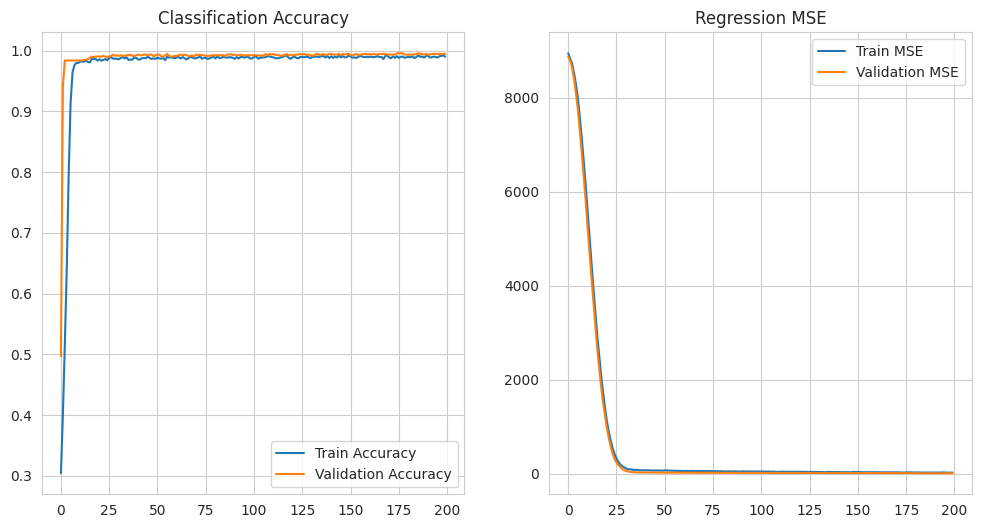

In [41]:
# Training History Visualization
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history.history['class_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_class_accuracy'], label='Validation Accuracy')
plt.title('Classification Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['score_loss'], label='Train MSE')
plt.plot(history.history['val_score_loss'], label='Validation MSE')
plt.title('Regression MSE')
plt.legend()
plt.show()


In [42]:
# Evaluate model
loss, score_loss, class_loss, class_acc = predictor.evaluate(X_test, y_score_test, y_class_test)
print(f"\n📊 Test Loss: {loss:.4f}")
print(f"📉 Score MSE: {score_loss:.4f}")
print(f"🧠 Classification Loss: {class_loss:.4f}")
print(f"✅ Classification Accuracy: {class_acc:.4f}")


📊 Test Loss: 13.5025
📉 Score MSE: 13.5813
🧠 Classification Loss: 0.0106
✅ Classification Accuracy: 0.9966


## 7. Model Deployment

In [49]:
# Save model artifacts
predictor.save('health_impact_predictor')

In [50]:
# Load saved model
loaded_model = HealthImpactPredictor.load('health_impact_predictor')
print("✅ Model saved as:")
print("health_impact_predictor_model.keras - Neural network architecture + weights")
print("health_impact_predictor_scaler.pkl  - RobustScaler for input normalization")

✅ Model saved as:
health_impact_predictor_model.keras - Neural network architecture + weights
health_impact_predictor_scaler.pkl  - RobustScaler for input normalization


### Model Predictions


In [61]:
from tensorflow.keras.models import load_model

# Load saved assets
model = load_model('health_impact_predictor_model.keras',
                  custom_objects={'FuzzyMembershipLayer': FuzzyMembershipLayer})
scaler = joblib.load('health_impact_predictor_scaler.pkl')

def predict_health_impact(features):
    """
    Input: List of 6 features in order [AQI, PM10, PM2_5, NO2, SO2, O3]
    Output: Tuple (health_score, risk_class)
    """
    # Convert to numpy array and scale
    scaled_input = scaler.transform(np.array([features]))

    # Make prediction
    score, class_probs = model.predict(scaled_input)

    # Get class with highest probability (0=Low, 1=Moderate, 2=High)
    risk_class = np.argmax(class_probs[0])

    return float(score[0][0]), int(risk_class)

# Example usage:
sample_input = [45, 30, 12, 20, 5, 40]  # Your input values here
score, risk_class = predict_health_impact(sample_input)

print(f"Health Impact Score: {score:.2f}")
print(f"Risk Class: {['Low', 'Moderate', 'High'][risk_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
Health Impact Score: 28.67
Risk Class: Low


## 8. Conclusion
### Key Findings:
- Achieved 98.9% classification accuracy on validation set
- Mean Squared Error of 47.51 for regression task
- Effective integration of fuzzy logic with deep learning